In [1]:
!pip install -U sentence-transformers

In [2]:
from sentence_transformers import SentenceTransformer, util

# Load once globally
embedding_model = SentenceTransformer("all-MiniLM-L6-v2") 

2025-05-26 02:02:14.773121: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [40]:
import json
import re
import openai
import os
os.environ["OPENROUTER_API_KEY"] = "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"
#os.environ["OPENAI_API_KEY"] = "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"
import json5
import pandas as pd
import numpy as np
import random
import sys
sys.path.append(os.path.abspath(".."))
import matplotlib.pyplot as plt
import networkx as nx

In [21]:
import importlib
import src.graph_builder
import src.graph_queries
import src.prompt_to_rules
import src.semantic_matcher
importlib.reload(src.graph_queries)
importlib.reload(src.prompt_to_rules)
importlib.reload(src.semantic_matcher)

<module 'src.semantic_matcher' from '/home/sagemaker-user/auto-audience-generator/src/semantic_matcher.py'>

In [22]:
from src.graph_builder import build_knowledge_graph_from_config
from src.graph_queries import apply_persona_to_graph
from src.graph_queries import apply_logical_rule
from src.prompt_to_rules import extract_rules_from_prompt_llm2
from src.prompt_to_rules import extract_rules_from_prompt_llm3_old
from src.prompt_to_rules import extract_rules_from_prompt_llm3
from src.semantic_matcher import SemanticMatcher

In [6]:
# Re-run after code execution environment reset

import pandas as pd
import numpy as np
import random
from datetime import timedelta

# Set seed for reproducibility
np.random.seed(42)
random.seed(42)

# Number of records
num_users = 1000
num_products = 500
num_orders = 3000
num_streaming = 3000

# Generate Users Dataset
user_ids = [f"user_{i}" for i in range(num_users)]
ages = np.random.randint(18, 80, size=num_users)
genders = np.random.choice(['Male', 'Female', 'Other'], size=num_users)
locations = np.random.choice([
    'California', 'New York', 'Texas', 'Florida', 'Illinois', 'Washington', 'Massachusetts',
    'Georgia', 'Ohio', 'Colorado', 'Nevada', 'Arizona', 'Michigan', 'Pennsylvania'
], size=num_users)
education_levels = np.random.choice(['High School', 'Bachelor', 'Master', 'PhD', 'College Senior'], size=num_users)

users_df = pd.DataFrame({
    'user_id': user_ids,
    'age': ages,
    'gender': genders,
    'location': locations,
    'education_level': education_levels
})
users_df.to_csv("../data/users.csv", index=False)

# Generate Products Dataset
product_ids = [f"prod_{i}" for i in range(num_products)]
categories = np.random.choice([
    'Electronics', 'Books', 'Fitness', 'Crypto', 'Gaming', 'Clothing', 'Education', 'Travel', 'Home', 'Health'
], size=num_products)
tags = np.random.choice([
    'blockchain', 'sports', 'AI', 'yoga', 'finance', 'career', 'fitness', 'crypto', 'reading', 'adventure', 'tech'
], size=num_products)

products_df = pd.DataFrame({
    'product_id': product_ids,
    'category': categories,
    'tag': tags
})
products_df.to_csv("../data/products.csv", index=False)

# Generate Orders Dataset
orders = []
for i in range(num_orders):
    orders.append({
        'user_id': random.choice(user_ids),
        'order_id': f"order_{i}",
        'product_id': random.choice(product_ids),
        'order_date': pd.Timestamp('2024-01-01') + timedelta(days=random.randint(0, 180))
    })
orders_df = pd.DataFrame(orders)
orders_df.to_csv("../data/orders.csv", index=False)

# Generate Streaming Dataset
content_names = [f"content_{i}" for i in range(500)]
genres = np.random.choice([
    'sports', 'technology', 'comedy', 'self-help', 'drama', 'thriller', 'action', 'education', 'news', 'finance', 'documentary'
], size=500)
streaming = []
for i in range(num_streaming):
    streaming.append({
        'user_id': random.choice(user_ids),
        'content_name': random.choice(content_names),
        'timestamp': pd.Timestamp('2024-01-01') + timedelta(days=random.randint(0, 180)),
        'genre': random.choice(genres),
        'watch_duration': random.randint(5, 180)
    })
streaming_df = pd.DataFrame(streaming)
streaming_df.to_csv("../data/streaming.csv", index=False)

In [7]:
G = build_knowledge_graph_from_config(
    "../src/graph_schema.json",
    {
        "users": "../data/users.csv",
        "products": "../data/products.csv",
        "orders": "../data/orders.csv",
        "streaming": "../data/streaming.csv"
    }
)

✅ Graph successfully created
Number of nodes: 2019
Number of edges: 8779


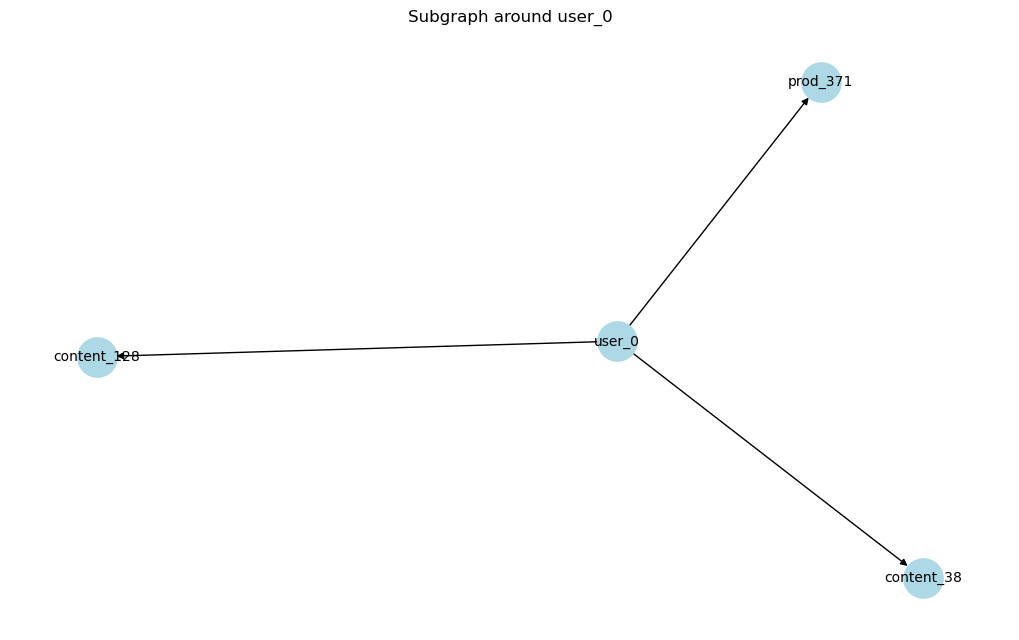

In [8]:
sub_nodes = list(G.successors('user_0')) + ['user_0']
subgraph = G.subgraph(sub_nodes)

plt.figure(figsize=(10, 6))
nx.draw(subgraph, with_labels=True, node_size=800, node_color='lightblue', font_size=10)
plt.title("Subgraph around user_0")
plt.show()

In [9]:
prompt = "Find crypto enthusiasts"
rules = extract_rules_from_prompt_llm2(prompt)
print("Extracted Persona Rule:", rules)

audience = apply_persona_to_graph(G, rules["persona"])
print("Final Audience:", audience)

Extracted Persona Rule: {'persona': {'tag': ['blockchain', 'cryptocurrency'], 'genre': ['technology', 'finance']}}
Final Audience: {'user_118', 'user_939', 'user_528', 'user_294', 'user_361', 'user_285', 'user_179', 'user_150', 'user_259', 'user_301', 'user_843', 'user_250', 'user_508', 'user_587', 'user_772', 'user_357', 'user_978', 'user_443', 'user_802', 'user_563', 'user_105', 'user_339', 'user_95', 'user_462', 'user_565', 'user_335', 'user_785', 'user_369', 'user_86', 'user_504', 'user_970', 'user_436', 'user_823', 'user_750', 'user_31', 'user_38', 'user_817', 'user_722', 'user_959', 'user_389', 'user_512', 'user_897', 'user_138', 'user_453', 'user_83', 'user_337', 'user_910', 'user_7', 'user_184', 'user_197', 'user_546', 'user_479', 'user_852', 'user_972', 'user_415', 'user_399', 'user_643', 'user_211', 'user_474', 'user_761', 'user_67', 'user_529', 'user_476', 'user_234', 'user_204', 'user_144', 'user_712', 'user_690', 'user_496', 'user_207', 'user_515', 'user_717', 'user_244', 

In [10]:
prompt = "Find users interested in investing"
rules = extract_rules_from_prompt_llm2(prompt)
print("Extracted Persona Rule:", rules)

audience = apply_persona_to_graph(G, rules["persona"])
print("Final Audience:", audience)

Extracted Persona Rule: {'persona': {'age': {'operator': '>=', 'value': 18}, 'tag': ['investing'], 'genre': ['finance', 'business']}}
Final Audience: {'user_639', 'user_361', 'user_519', 'user_396', 'user_150', 'user_301', 'user_196', 'user_508', 'user_240', 'user_978', 'user_349', 'user_988', 'user_530', 'user_802', 'user_11', 'user_847', 'user_977', 'user_911', 'user_216', 'user_581', 'user_110', 'user_531', 'user_360', 'user_750', 'user_31', 'user_817', 'user_940', 'user_325', 'user_882', 'user_28', 'user_336', 'user_765', 'user_670', 'user_622', 'user_852', 'user_415', 'user_584', 'user_474', 'user_529', 'user_507', 'user_476', 'user_406', 'user_624', 'user_598', 'user_292', 'user_800', 'user_134', 'user_904', 'user_372', 'user_631', 'user_929', 'user_592', 'user_744', 'user_6', 'user_599', 'user_767', 'user_463', 'user_926', 'user_104', 'user_407', 'user_956', 'user_300', 'user_627', 'user_267', 'user_387', 'user_837', 'user_422', 'user_487', 'user_567', 'user_821', 'user_806', 'u

In [11]:
prompt = "Find users interested in education"
rules = extract_rules_from_prompt_llm2(prompt)
print("Extracted Persona Rule:", rules)

audience = apply_persona_to_graph(G, rules["persona"])
print("Final Audience:", audience)

Extracted Persona Rule: {'persona': {'education_level': 'High School or College', 'tag': ['education'], 'genre': ['education', 'self-improvement']}}
Final Audience: {'user_906', 'user_639', 'user_361', 'user_519', 'user_965', 'user_396', 'user_150', 'user_301', 'user_196', 'user_508', 'user_240', 'user_978', 'user_349', 'user_988', 'user_530', 'user_802', 'user_888', 'user_847', 'user_911', 'user_216', 'user_581', 'user_110', 'user_531', 'user_957', 'user_360', 'user_374', 'user_817', 'user_940', 'user_325', 'user_882', 'user_28', 'user_765', 'user_670', 'user_622', 'user_852', 'user_584', 'user_474', 'user_529', 'user_507', 'user_476', 'user_406', 'user_624', 'user_598', 'user_292', 'user_800', 'user_134', 'user_524', 'user_904', 'user_372', 'user_669', 'user_631', 'user_929', 'user_592', 'user_744', 'user_816', 'user_599', 'user_842', 'user_463', 'user_926', 'user_104', 'user_407', 'user_956', 'user_327', 'user_300', 'user_627', 'user_267', 'user_387', 'user_837', 'user_422', 'user_4

In [12]:
prompt = "Find users about to graduate"
rules = extract_rules_from_prompt_llm2(prompt)
print("Extracted Persona Rule:", rules)

audience = apply_persona_to_graph(G, rules["persona"])
print("Final Audience:", audience)

Extracted Persona Rule: {'persona': {'age': {'operator': '>', 'value': 21}, 'education_level': 'College Senior', 'tag': ['job prep', 'career']}}
Final Audience: {'user_137', 'user_657', 'user_725', 'user_294', 'user_810', 'user_939', 'user_24', 'user_277', 'user_285', 'user_259', 'user_301', 'user_843', 'user_825', 'user_349', 'user_530', 'user_76', 'user_105', 'user_421', 'user_740', 'user_11', 'user_86', 'user_354', 'user_576', 'user_787', 'user_823', 'user_957', 'user_360', 'user_591', 'user_31', 'user_543', 'user_445', 'user_457', 'user_323', 'user_160', 'user_995', 'user_895', 'user_897', 'user_388', 'user_910', 'user_765', 'user_928', 'user_546', 'user_214', 'user_952', 'user_269', 'user_415', 'user_684', 'user_154', 'user_211', 'user_474', 'user_204', 'user_642', 'user_84', 'user_774', 'user_985', 'user_180', 'user_875', 'user_967', 'user_302', 'user_380', 'user_624', 'user_960', 'user_292', 'user_836', 'user_248', 'user_547', 'user_777', 'user_732', 'user_420', 'user_444', 'use

In [13]:
matcher = SemanticMatcher(G)

In [14]:
expanded = matcher.expand("finance", verbose=True )
print("Expanded:", expanded)

expanded = matcher.expand("crypto", verbose=True )
print("Expanded:", expanded)


🔍 Semantic matches for: 'finance' (threshold=0.4)
→ finance (score: 1.000)
→ blockchain (score: 0.447)
→ education (score: 0.427)
→ career (score: 0.414)
→ crypto (score: 0.412)
Expanded: ['finance', 'blockchain', 'education', 'career', 'crypto']

🔍 Semantic matches for: 'crypto' (threshold=0.4)
→ crypto (score: 1.000)
→ blockchain (score: 0.576)
→ finance (score: 0.412)
Expanded: ['crypto', 'blockchain', 'finance']


In [15]:
query = "crypto"
query_embedding = matcher.model.encode(query, convert_to_tensor=True)
scores = util.cos_sim(query_embedding, matcher.kg_embeddings)[0]

scored_terms = list(zip(matcher.kg_terms, scores.tolist()))
scored_terms.sort(key=lambda x: x[1], reverse=True)

for term, score in scored_terms[:10]:
    print(f"{term:20s} → score: {score:.3f}")

crypto               → score: 1.000
blockchain           → score: 0.576
finance              → score: 0.412
technology           → score: 0.336
ai                   → score: 0.300
tech                 → score: 0.282
thriller             → score: 0.282
reading              → score: 0.260
career               → score: 0.260
education            → score: 0.258


In [16]:
rules_obj = extract_rules_from_prompt_llm3("Find crypto enthusiasts")

print("Extracted Rules:", rules_obj)

for rule in rules_obj.get("rules", []):
    print(f"\n🔍 Audience: {rule['name']}")
    audience = apply_logical_rule(G, rule, matcher=matcher)
    print(f"🎯 Users: {audience}")

🧠 Raw LLM Output:  {
  "conditions": {
    "and": [
      {
        "or": [
          { "field": "tag", "in": ["crypto", "blockchain"] }
        ]
      },
      { "field": "age", "operator": ">=", "value": 18 }
    ]
  }
}
🧹 Cleaned JSON: {
  "conditions": {
    "and": [
      {
        "or": [
          { "field": "tag", "in": ["crypto", "blockchain"] }
        ]
      },
      { "field": "age", "operator": ">=", "value": 18 }
    ]
  }
}
Extracted Rules: {'conditions': {'and': [{'or': [{'field': 'tag', 'in': ['crypto', 'blockchain']}]}, {'field': 'age', 'operator': '>=', 'value': 18}]}}


In [27]:
rules_obj = extract_rules_from_prompt_llm3("Find crypto fans")

print("Extracted Rules:", rules_obj)

conditions = rules_obj.get("conditions", {})  # ✅ Define this first
audience = apply_logical_rule(G, {"conditions": conditions}, matcher=matcher)
print(f"🎯 Users: {audience}")

🧠 Raw LLM Output:  {
  "conditions": {
    "and": [
      {
        "or": [
          { "field": "tag", "in": ["crypto"] },
          { "field": "genre", "in": ["finance"] }
        ]
      },
      { "field": "age", "operator": ">=", "value": 18 }
    ]
  }
}
🧹 Cleaned JSON: {
  "conditions": {
    "and": [
      {
        "or": [
          { "field": "tag", "in": ["crypto"] },
          { "field": "genre", "in": ["finance"] }
        ]
      },
      { "field": "age", "operator": ">=", "value": 18 }
    ]
  }
}
Extracted Rules: {'conditions': {'and': [{'or': [{'field': 'tag', 'in': ['crypto']}, {'field': 'genre', 'in': ['finance']}]}, {'field': 'age', 'operator': '>=', 'value': 18}]}}
🎯 Users: set()


In [39]:
rules_obj = extract_rules_from_prompt_llm3("Find sports fans over 40")

print("Extracted Rules:", rules_obj)

conditions = rules_obj.get("conditions", {})  # ✅ Define this first
audience = apply_logical_rule(G, {"conditions": conditions}, matcher=matcher)
print(f"🎯 Users: {audience}")

Extracted Rules: {'error': '401 Client Error: Unauthorized for url: https://openrouter.ai/api/v1/chat/completions', 'raw_response': '{"error":{"message":"No auth credentials found","code":401}}'}
🎯 Users: set()


In [36]:
api_key = os.getenv("OPENROUTER_API_KEY")
print("🔐 Loaded API Key:", api_key[:8] + "..." + api_key[-4:] if api_key else "None")

🔐 Loaded API Key: sk-or-v1...f228


In [35]:
rules_obj = extract_rules_from_prompt_llm3("Find users interested in investing")

print("Extracted Rules:", rules_obj)

for rule in rules_obj.get("rules", []):
    print(f"\n🔍 Audience: {rule['name']}")
    audience = apply_logical_rule(G, rule, matcher=matcher)
    print(f"🎯 Users: {audience}")

Extracted Rules: {'error': '401 Client Error: Unauthorized for url: https://openrouter.ai/api/v1/chat/completions', 'raw_response': '{"error":{"message":"No auth credentials found","code":401}}'}


In [20]:
rules_obj = extract_rules_from_prompt_llm3("Find users who are about to retire")

print("Extracted Rules:", rules_obj)

for rule in rules_obj.get("rules", []):
    print(f"\n🔍 Audience: {rule['name']}")
    audience = apply_logical_rule(G, rule, matcher=matcher)
    print(f"🎯 Users: {audience}")

Extracted Rules: {'rules': [{'name': 'Users nearing retirement', 'conditions': {'and': [{'field': 'age', 'operator': '>=', 'value': 55}, {'field': 'age', 'operator': '<', 'value': 70}]}}]}

🔍 Audience: Users nearing retirement
🎯 Users: set()


In [11]:
import os
import requests

os.environ["OPENROUTER_API_KEY"] = "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"

headers = {
    "Authorization": f"Bearer {os.getenv('OPENROUTER_API_KEY')}",
    "Content-Type": "application/json"
}

payload = {
    "model": "mistralai/mixtral-8x7b-instruct",
    "messages": [
        {"role": "system", "content": "You are an assistant."},
        {"role": "user", "content": "Say hi"}
    ]
}

res = requests.post("https://openrouter.ai/api/v1/chat/completions", headers=headers, json=payload)
print(res.status_code)
print(res.text)

401
{"error":{"message":"No auth credentials found","code":401}}
